In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 2. Genre analysis

### 2.1. Database load and preprocessing

In [2]:
imdb_data = pd.read_csv("imdb_top_1000.csv")

In [3]:
imdb_data["Gross"] = imdb_data["Gross"].apply(lambda x: float(x.replace(",", "")) if isinstance(x, str) else x)
imdb_data["Released_Year"] = pd.to_datetime(imdb_data["Released_Year"], format="%Y", errors="coerce")
imdb_data["Runtime"] = imdb_data["Runtime"].apply(lambda x: int(x.split()[0]))
imdb_data["Genre"] = imdb_data["Genre"].apply(lambda x: x.split(", "))

In [4]:
TOTAL_MOVIES = len(imdb_data)

### 2.2. Common genres

In [5]:
imdb_data.Genre.value_counts()

Genre
[Drama]                        85
[Drama, Romance]               37
[Comedy, Drama]                35
[Comedy, Drama, Romance]       31
[Action, Crime, Drama]         30
                               ..
[Adventure, Thriller]           1
[Animation, Action, Sci-Fi]     1
[Action, Crime, Comedy]         1
[Animation, Crime, Mystery]     1
[Adventure, Comedy, War]        1
Name: count, Length: 202, dtype: int64

By flattening the Genre column, we can calculate the percentage of movies that have a certain genre listed.

In [6]:
genre_list = pd.Series(np.concatenate(imdb_data.Genre))

genre_counts = genre_list.value_counts()
genre_percentages = (genre_counts / len(imdb_data)) * 100

print("Top 5 Genres:\n")
print(genre_percentages.head())

Top 5 Genres:

Drama        72.4
Comedy       23.3
Crime        20.9
Adventure    19.6
Action       18.9
Name: count, dtype: float64


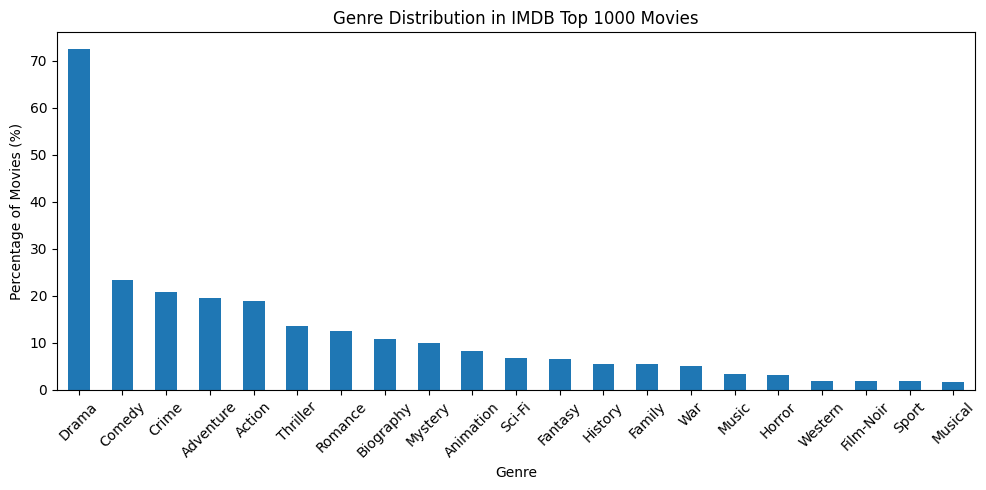

In [7]:
plt.figure(figsize=(10, 5))

genre_percentages.plot(kind="bar")
plt.title("Genre Distribution in IMDB Top 1000 Movies")
plt.xlabel("Genre")
plt.ylabel("Percentage of Movies (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Most common genre by far is Drama, followed by Comedy with a third of the previous genre.

### 2.3. Genre combinations

Movies with only one genre listed:

In [8]:
single_genre_counts = imdb_data.Genre[imdb_data.Genre.apply(lambda x: len(x) == 1)].value_counts()

single_genre_counts

Genre
[Drama]       85
[Comedy]      13
[Western]      4
[Horror]       2
[Thriller]     1
Name: count, dtype: int64

In [9]:
single_genre_percentage = (single_genre_counts.sum() / TOTAL_MOVIES) * 100

print(f"Percentage of movies with a single genre: {single_genre_percentage:.2f}%")

Percentage of movies with a single genre: 10.50%


For genre combinations, we can look into the combinations already listed in the database and also examine common genre pairs. 

#### 2.3.1. Genre combinations as listed

In [10]:
multiple_genres = imdb_data[imdb_data.Genre.apply(lambda x: len(x) > 1)].copy()
multiple_genres["Genre"] = multiple_genres["Genre"].apply(lambda x: tuple(sorted(x)))

multiple_genres.Genre.value_counts(normalize=True) * 100

Genre
(Drama, Romance)               4.134078
(Comedy, Drama)                3.910615
(Comedy, Drama, Romance)       3.463687
(Action, Crime, Drama)         3.351955
(Biography, Drama, History)    3.128492
                                 ...   
(Adventure, Thriller)          0.111732
(Action, Animation, Sci-Fi)    0.111732
(Animation, Crime, Mystery)    0.111732
(Crime, Drama, Musical)        0.111732
(Adventure, Comedy, War)       0.111732
Name: proportion, Length: 196, dtype: float64

There are a lot of different combinations, so even though there are some sets that are more frequent (e.g. Drama and Romance), most have a very low frequency. Genre pair combination can give us more insightful descriptions.

#### 2.3.2. Genre pair combinations

Extract all possible genre pairs and count their occurrences

In [11]:
from itertools import combinations

In [12]:
genre_pairs = []
for genres in multiple_genres.Genre:
    if len(genres) > 1:
        genre_pairs.extend(combinations(sorted(genres), 2))

pair_percentages = pd.Series(genre_pairs).value_counts(normalize=True) * 100

In [13]:
pair_percentages.head(10)

(Crime, Drama)         7.315958
(Comedy, Drama)        5.624143
(Drama, Romance)       4.846822
(Biography, Drama)     4.709648
(Action, Adventure)    3.795153
(Drama, Thriller)      3.795153
(Action, Drama)        3.520805
(Adventure, Drama)     2.972108
(Drama, Mystery)       2.972108
(Action, Crime)        2.514861
Name: proportion, dtype: float64

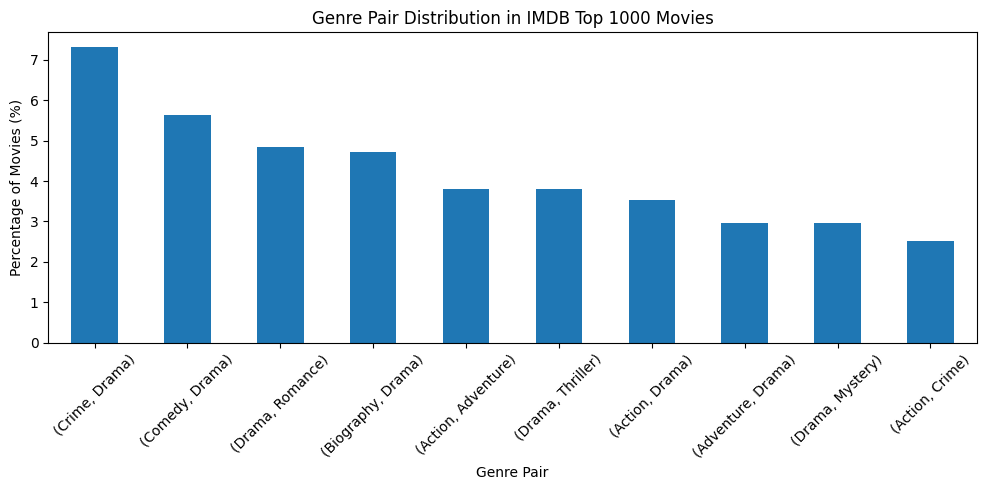

In [14]:
plt.figure(figsize=(10, 5))
pair_percentages.head(10).plot(kind="bar")
plt.title("Genre Pair Distribution in IMDB Top 1000 Movies")
plt.xlabel("Genre Pair")
plt.ylabel("Percentage of Movies (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Out of all the movies that have multiple genres assigned, 7% belong to both Crime and Drama genres. Drama is also present in most of the top 10 frequent genre pair combinations, except for Action Adventure and Action Crime. This is explained by the over-representation of the Drama genre in the whole database.

We can now evaluate the average ratings of the top combinations.

In [15]:
genre_pair_ratings = {}
for index, row in multiple_genres.iterrows():
    genres = row["Genre"]
    rating = row["IMDB_Rating"]
    if len(genres) > 1:
        for pair in combinations(sorted(genres), 2):
            if pair not in genre_pair_ratings:
                genre_pair_ratings[pair] = []
            genre_pair_ratings[pair].append(rating)

# Calculate average ratings for each genre pair
average_genre_pair_ratings = {pair: np.mean(ratings) for pair, ratings in genre_pair_ratings.items()}
count_genre_pair_ratings = {pair: len(ratings) for pair, ratings in genre_pair_ratings.items()}
average_genre_pair_ratings = [
    [pair, average_genre_pair_ratings[pair], count_genre_pair_ratings[pair]]
    for pair in average_genre_pair_ratings
]

average_genre_pair_ratings = pd.DataFrame(
    average_genre_pair_ratings, columns=["genre_pair", "average_rating", "movie_count"]
)

In [16]:
average_genre_pair_ratings.sort_values(by="movie_count", ascending=False).head(10)

,genre_pair,average_rating,movie_count
0,"(Crime, Drama)",7.973750,160
14,"(Comedy, Drama)",7.907317,123
10,"(Drama, Romance)",7.907547,106
5,"(Biography, Drama)",7.940777,103
3,"(Action, Adventure)",7.968675,83
16,"(Drama, Thriller)",7.913253,83
2,"(Action, Drama)",7.979221,77
4,"(Adventure, Drama)",8.009231,65
26,"(Drama, Mystery)",7.973846,65
1,"(Action, Crime)",7.872727,55


The ratings for the most frequent genres are reduced because of the high variability in ratings for all the movies. Less frequent genres have a greater average rating due to consisting of only one or two highly rated movies, as seen below.

In [17]:
average_genre_pair_ratings.sort_values(by="average_rating", ascending=False).head(10)

,genre_pair,average_rating,movie_count
37,"(Animation, War)",8.50,1
49,"(Mystery, War)",8.35,2
56,"(Crime, Music)",8.30,1
64,"(Crime, Sci-Fi)",8.30,1
70,"(Musical, Romance)",8.30,1
61,"(Family, Sport)",8.25,2
83,"(Fantasy, History)",8.20,1
76,"(Fantasy, War)",8.20,1
75,"(Action, Sport)",8.20,1
58,"(Romance, Sci-Fi)",8.15,2


<Figure size 1500x500 with 0 Axes>

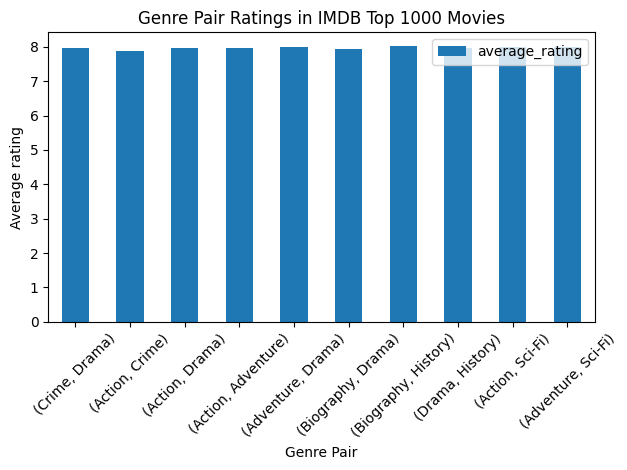

In [18]:
plt.figure(figsize=(15, 5))
average_genre_pair_ratings.head(10).plot(x="genre_pair", y="average_rating", kind="bar")
plt.title("Genre Pair Ratings in IMDB Top 1000 Movies")
plt.xlabel("Genre Pair")
plt.ylabel("Average rating")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2.4. Genre over decades

We can generate an entry for each different genre and then plot their frequencies each decade.

In [19]:
imdb_data["Decade"] = imdb_data["Released_Year"].apply(lambda x: int(x.year // 10 * 10) if x is not pd.NaT else pd.NaT)

In [20]:
imdb_data_by_genre = imdb_data.explode("Genre")

decade_genre_counts = imdb_data_by_genre.groupby(["Decade", "Genre"]).size().unstack(fill_value=0)

<Axes: title={'center': 'Genre Distribution Over Decades'}, xlabel='Decade'>

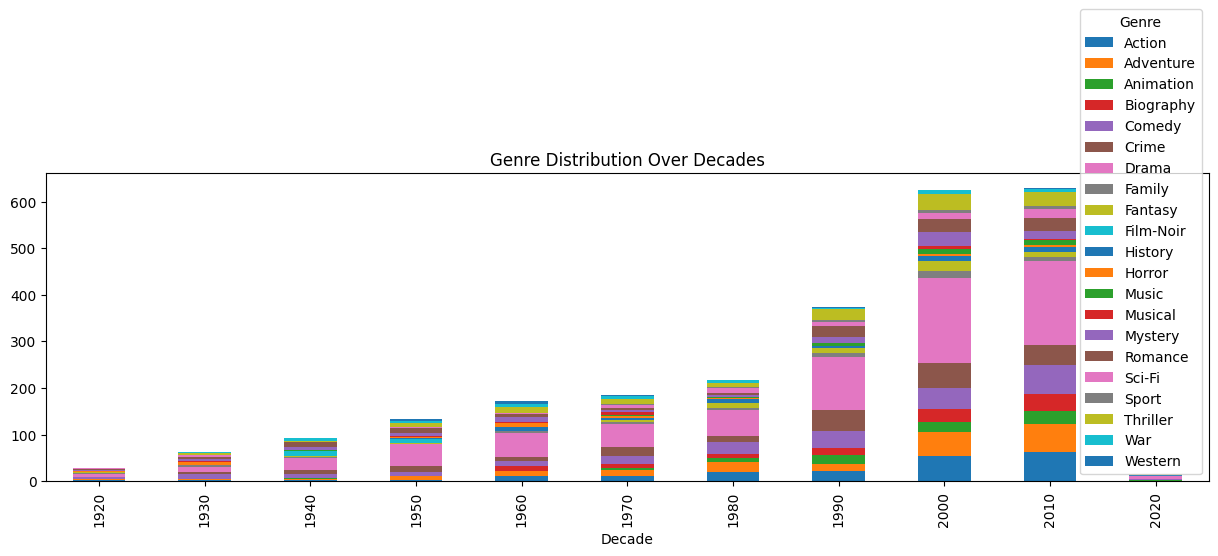

In [21]:
decade_genre_counts.plot(kind="bar", stacked=True, figsize=(15, 4), title="Genre Distribution Over Decades")

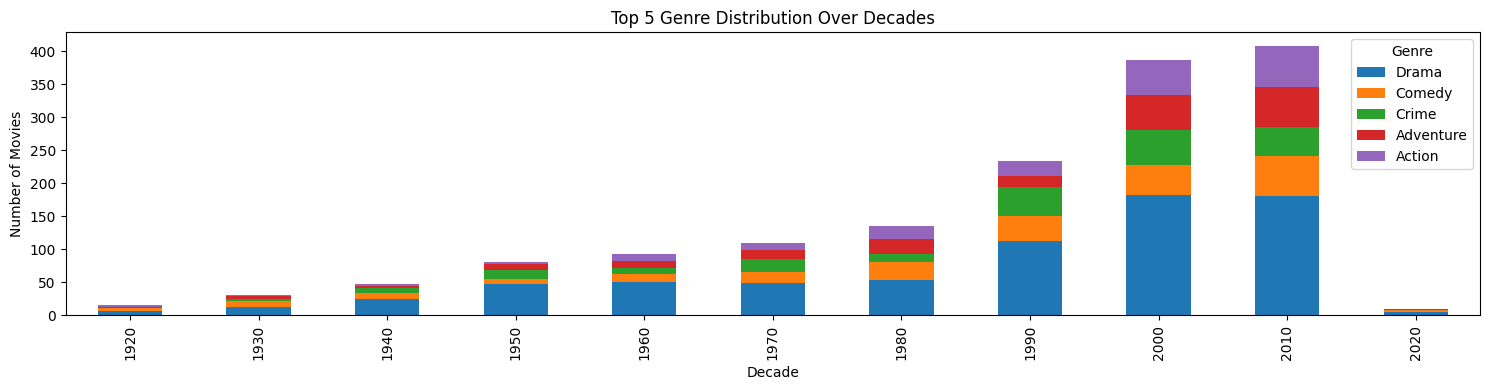

In [26]:
# plot the top 5 most frequent genres every decade
top_genres = genre_counts.head(5).index.tolist()
decade_top_genre_counts = decade_genre_counts[top_genres]
decade_top_genre_counts.plot(kind="bar", stacked=True, figsize=(15, 4), title="Top 5 Genre Distribution Over Decades")
plt.xlabel("Decade")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()


In [40]:
imdb_data_by_genre.groupby(['Decade'])['Genre'].value_counts(normalize=True)#.loc[1920, :]

Decade  Genre    
1920    Drama        0.206897
        Comedy       0.172414
        Romance      0.103448
        Action       0.068966
        Adventure    0.068966
                       ...   
2020    Adventure    0.066667
        Animation    0.066667
        Biography    0.066667
        Romance      0.066667
        Thriller     0.066667
Name: proportion, Length: 186, dtype: float64

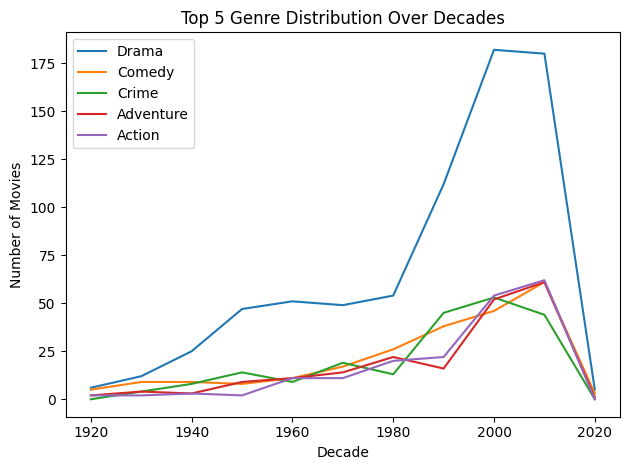

In [39]:
# plot count of the top 5 most popular genre per decade as a line for each genre independently
top_5_genres = imdb_data_by_genre.groupby(['Decade', 'Genre']).size().unstack().fillna(0).astype(int).loc[:, genre_counts.index[:5]]
for genre in top_5_genres.columns:
    plt.plot(top_5_genres.index, top_5_genres[genre], label=genre)

plt.title(f"Top 5 Genre Distribution Over Decades")
plt.xlabel("Decade")
plt.ylabel("Number of Movies")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
imdb_data_by_genre.groupby(["Decade", "Genre"]).aggregate(
    {"IMDB_Rating": "count"}
).reset_index().sort_values(by="IMDB_Rating", ascending=False).groupby(
    "Decade"
).aggregate(
    {"Genre": "first"}
)

,Genre
Decade,
1920,Drama
1930,Drama
1940,Drama
1950,Drama
1960,Drama
1970,Drama
1980,Drama
1990,Drama
2000,Drama


As expected from the initial common genres results, Drama is the most common genre for all decades. From the top 5, the frequency of Action movies has increased throughout the decades while Comedy, Crime and Adventure have always been present in some percentage.

In [24]:
imdb_data_by_genre.groupby(["Decade", "Genre"]).aggregate({"IMDB_Rating": "mean"}).unstack()

IMDB_Rating                                                    \
Genre       Action Adventure Animation Biography    Comedy     Crime   
Decade                                                                 
1920      8.150000  8.150000       NaN  8.100000  8.180000       NaN   
1930      7.850000  7.900000       NaN       NaN  8.077778  7.925000   
1940      7.900000  7.933333  7.700000       NaN  8.022222  8.012500   
1950      8.300000  8.088889       NaN       NaN  7.937500  8.128571   
1960      7.927273  7.909091  7.600000  7.977778  7.927273  8.044444   
1970      7.854545  7.914286  7.700000  7.890000  7.923529  7.984211   
1980      7.990000  8.027273  7.987500  7.955556  7.834615  7.861538   
1990      8.000000  7.912500  7.966667  7.960000  7.850000  8.006667   
2000      7.937037  7.957692  7.945455  7.881481  7.891304  7.877358   
2010      7.935484  7.927869  7.917857  7.940541  7.893443  7.927273   
2020           NaN  8.100000  8.100000  8.600000  7.933333       NaN   

                                                ...                           \
Genre      Drama    Family   Fantasy Film-Noir  ... Horror     Music Musical   
Decade                                          ...                            
1920    8.166667  8.300000  8.000000       NaN  ...  8.000       NaN     NaN   
1930    8.033333  8.100000  8.000000       NaN  ...  7.820  7.900000    7.85   
1940    8.060000  8.066667  8.150000  7.945455  ...    NaN  8.100000     NaN   
1950    8.042553       NaN  8.050000  8.050000  ...  7.850  8.200000    8.30   
1960    7.972549  7.800000  7.950000       NaN  ...  7.900  7.600000    7.70   
1970    8.014286  7.800000  8.125000       NaN  ...  8.000  7.966667    7.98   
1980    7.966667  7.883333  8.027273       NaN  ...  8.250  8.000000     NaN   
1990    7.975000  7.840000  7.900000       NaN  ...    NaN  7.920000     NaN   
2000    7.903297  7.956250  7.795238       NaN  ...  7.675  7.836364    8.00   
2010    7.935000  7.887500  7.972727       NaN  ...  7.825  7.950000    7.90   
2020    8.140000       NaN       NaN       NaN  ...    NaN       NaN     NaN   

                                                                              
Genre    Mystery   Romance    Sci-Fi     Sport  Thriller       War   Western  
Decade                                                                        
1920    8.100000  8.133333  8.300000       NaN  8.000000       NaN       NaN  
1930    7.925000  8.080000  7.800000       NaN  7.900000  7.966667  7.800000  
1940    8.057143  8.020000       NaN       NaN  7.966667  8.140000  8.200000  
1950    8.228571  7.960000  7.700000       NaN  8.155556  8.025000  7.850000  
1960    8.066667  7.900000  8.150000  8.000000  7.908333  7.928571  8.185714  
1970    8.080000  7.920000  8.066667  8.100000  7.800000  7.871429  7.700000  
1980    7.800000  7.950000  7.966667  8.200000  7.933333  8.200000       NaN  
1990    7.964286  7.975000  8.012500  8.000000  7.900000  8.100000  8.100000  
2000    7.877419  7.907143  7.961538  7.900000  7.850000  7.912500       NaN  
2010    7.947059  7.810714  7.984211  7.842857  7.940000  8.057143  8.000000  
2020         NaN  7.900000       NaN       NaN  7.800000       NaN       NaN  

[11 rows x 21 columns]

In [35]:
imdb_data_by_genre.groupby(["Decade", "Genre"]).aggregate({"IMDB_Rating": "count"})


IMDB_Rating
Decade Genre                 
1920   Action               2
       Adventure            2
       Biography            1
       Comedy               5
       Drama                6
...                       ...
2020   Comedy               3
       Drama                5
       History              2
       Romance              1
       Thriller             1

[186 rows x 1 columns]